In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col='DATE', parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


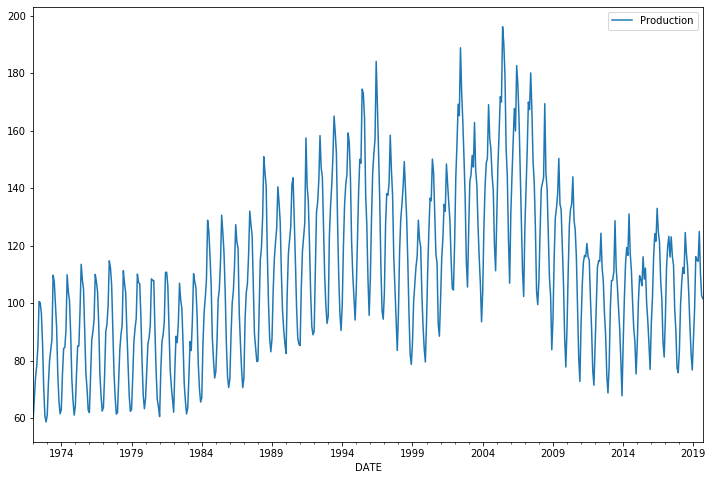

In [7]:
df.plot(figsize=(12,8))

### Train/Test Split

In [8]:
len(df)

573

In [9]:
test_size = 24

test_ind = len(df) - test_size

In [10]:
train = df.iloc[:test_ind]

test = df.iloc[test_ind:]

In [11]:
len(test)

24

### Scaling the Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

### Time Series Generator for scaled_train data

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 18

n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

In [17]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM

In [18]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Time Series Generator for scaled_test data/validation data

In [20]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

### Early Stopping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

### Fit the Model

In [23]:
model.fit_generator(generator, validation_data = validation_generator, epochs=20, callbacks=[early_stop])

Epoch 1/20
531/531 [==============================] - 17s 33ms/step - loss: 0.0221 - val_loss: 0.0064
Epoch 2/20
531/531 [==============================] - 18s 34ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 3/20
531/531 [==============================] - 17s 33ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 4/20
531/531 [==============================] - 17s 33ms/step - loss: 0.0035 - val_loss: 0.0017


### Plot the loss occured during Training

In [24]:
losses = pd.DataFrame(model.history.history)

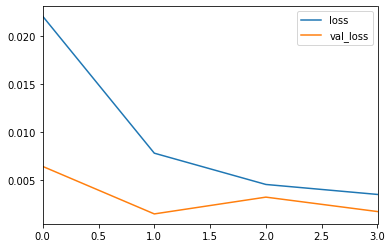

In [25]:
losses.plot()

### Evaluate on Test Data

* Forecast predictions on the entire test data range

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

### Inverse Transformation

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions

c:\users\tvnsk\anaconda3x\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,89.359151
2017-11-01,77.4378,81.582946
2017-12-01,75.8118,79.852149
2018-01-01,83.4343,86.066485
2018-02-01,99.4899,96.447805
2018-03-01,107.3152,105.183530
2018-04-01,112.4309,111.679849
2018-05-01,110.3544,115.411192
2018-06-01,124.5841,115.427437


### Plot Actual values vs Prediction values

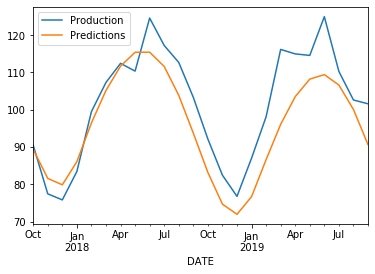

In [30]:
test.plot()

#### Calculate RMSE

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

8.48230249635856

##### Is this good enough?

##### `Changes we can make to improve the performance `

* activation function

* no.of LSTM units (to 150)

* test_size (may be to 18 months)

* length of the batch (may be to 12 months)   # this is the absolute least value we can choose to grab the yearly information

* If we increase to too many neurons it may result in overfitting as well